In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import torch
import numpy as np
import ast
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import os

In [2]:
# ['education-num', 'sex', 'workclass_index', 'occupation_index', 'relationship_index', 'race_index', 'native-country_index',
# 'age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
# 前7个特征是离散特征，后5个特征是连续特征
df=pd.read_csv("data/exp1/raw.csv")
df

,vectorized_features_1,income,marital-status
0,"[13.0, 1.0, 3.0, 3.0, 1.0, 0.0, 0.0, 39.0, 775...",0,0
1,"[13.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 50.0, 833...",0,1
2,"[9.0, 1.0, 0.0, 8.0, 1.0, 0.0, 0.0, 38.0, 2156...",0,1
3,"[7.0, 1.0, 0.0, 8.0, 0.0, 1.0, 0.0, 53.0, 2347...",0,1
4,"[13.0, 0.0, 0.0, 1.0, 4.0, 1.0, 8.0, 28.0, 338...",0,1
...,...,...,...
45217,"[13.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 33.0, 245...",0,0
45218,"[13.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 39.0, 215...",0,1
45219,"[13.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 38.0, 374...",0,1
45220,"[13.0, 1.0, 0.0, 3.0, 2.0, 2.0, 0.0, 44.0, 838...",0,1


In [3]:
df['vectorized_features_1'] = df['vectorized_features_1'].apply(ast.literal_eval)

In [4]:
x=torch.from_numpy(np.array(df['vectorized_features_1'].values.tolist(),np.float32))
x_d=x[:,:7].long() # 前7维是离散变量，要转为long类型才能送入embedding层
x_c=x[:,7:] # 后5维是连续变量
y1=torch.from_numpy(np.array(df['income'].values.tolist(),np.float32))
y2=torch.from_numpy(np.array(df['marital-status'].values.tolist(),np.float32))
print(x_d)
print(x_d.shape)
print(x_c)
print(x_c.shape)
print(y1)
print(y1.shape)
print(y2)
print(y2.shape)

tensor([[13,  1,  3,  ...,  1,  0,  0],
        [13,  1,  1,  ...,  0,  0,  0],
        [ 9,  1,  0,  ...,  1,  0,  0],
        ...,
        [13,  1,  0,  ...,  0,  0,  0],
        [13,  1,  0,  ...,  2,  2,  0],
        [13,  1,  4,  ...,  0,  0,  0]])
torch.Size([45222, 7])
tensor([[3.9000e+01, 7.7516e+04, 2.1740e+03, 0.0000e+00, 4.0000e+01],
        [5.0000e+01, 8.3311e+04, 0.0000e+00, 0.0000e+00, 1.3000e+01],
        [3.8000e+01, 2.1565e+05, 0.0000e+00, 0.0000e+00, 4.0000e+01],
        ...,
        [3.8000e+01, 3.7498e+05, 0.0000e+00, 0.0000e+00, 5.0000e+01],
        [4.4000e+01, 8.3891e+04, 5.4550e+03, 0.0000e+00, 4.0000e+01],
        [3.5000e+01, 1.8215e+05, 0.0000e+00, 0.0000e+00, 6.0000e+01]])
torch.Size([45222, 5])
tensor([0., 0., 0.,  ..., 0., 0., 1.])
torch.Size([45222])
tensor([0., 1., 1.,  ..., 1., 1., 1.])
torch.Size([45222])


计算两个任务的标签间的pearson相关系数

In [5]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(y1, y2)
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.31953582278616827
P-value: 0.0


In [6]:
class MyDataset(Dataset):
    def __init__(self,x_discrete,x_continuous,y1,y2):
        self.x_d=x_discrete
        self.x_c=x_continuous
        self.y1=y1
        self.y2=y2
    def __len__(self):
        return self.x_d.shape[0]
    def __getitem__(self,idx):
        return (self.x_d[idx],x_c[idx],self.y1[idx],self.y2[idx])

In [7]:
# 训练集30000个样本
train_dataset=MyDataset(x_d[:30000],x_c[:30000],y1[:30000],y2[:30000])
# 验证集7500个样本
val_dataset=MyDataset(x_d[30000:37500],x_c[30000:37500],y1[30000:37500],y2[30000:37500])
# 测试集7500个样本
test_dataset=MyDataset(x_d[37500:45000],x_c[30000:37500],y1[37500:45000],y2[37500:45000])

In [8]:
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, expert_dropout):  # input_dim代表输入维度，output_dim代表输出维度
        super(Expert, self).__init__()

        expert_hidden_layers = [64, 32]
        self.expert_layer = nn.Sequential(
            nn.Linear(input_dim, expert_hidden_layers[0]),
            nn.ReLU(),
            nn.Dropout(expert_dropout),
            nn.Linear(expert_hidden_layers[0], expert_hidden_layers[1]),
            nn.ReLU(),
            nn.Dropout(expert_dropout),
            nn.Linear(expert_hidden_layers[1], output_dim),
            nn.ReLU(),
            nn.Dropout(expert_dropout)
        )

    def forward(self, x):
        out = self.expert_layer(x)
        return out


class Expert_Gate(nn.Module):
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, expert_dropout,
                 use_gate=True):  # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)  use_gate：是否使用门控，如果不使用则各个专家取平均
        super(Expert_Gate, self).__init__()
        self.n_task = n_task
        self.use_gate = use_gate

        '''专家网络'''
        for i in range(n_expert):
            setattr(self, "expert_layer" + str(i + 1), Expert(feature_dim, expert_dim, expert_dropout))
        self.expert_layers = [getattr(self, "expert_layer" + str(i + 1)) for i in range(n_expert)]  # 为每个expert创建一个DNN

        '''门控网络'''
        for i in range(n_task):
            setattr(self, "gate_layer" + str(i + 1), nn.Sequential(nn.Linear(feature_dim, n_expert), nn.Softmax(dim=1)))
        self.gate_layers = [getattr(self, "gate_layer" + str(i + 1)) for i in range(n_task)]  # 为每个gate创建一个lr+softmax

    def forward(self, x):
        if self.use_gate:
            # 多个专家网络的输出
            E_net = [expert(x) for expert in self.expert_layers]
            E_net = torch.cat(([e[:, np.newaxis, :] for e in E_net]), dim=1)  # (b,n_expert,expert_dim)

            # 多个门网络的输出
            gate_net = [gate(x) for gate in self.gate_layers]  # n_task个(b,n_expert)

            # towers计算：对应的门网络乘上所有的专家网络
            towers_input = []
            for i in range(self.n_task):
                g = gate_net[i].unsqueeze(2)  # (b,n_expert,1)
                tower_input = torch.matmul(E_net.transpose(1, 2), g)  # (b,d,n_expert)@(b,n_expert,1)-->(b,expert_dim,1)
                towers_input.append(tower_input.squeeze(2))  # (b, expert_dim)
        else:
            E_net = [expert(x) for expert in self.expert_layers]
            towers_input = sum(E_net) / len(E_net)
        return towers_input

In [9]:
class MMoE(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, use_gate=True, tower_dropout=0, expert_dropout=0):
        super(MMoE, self).__init__()

        self.n_task = n_task
        self.use_gate = use_gate
        self.Expert_Gate = Expert_Gate(feature_dim=feature_dim, expert_dim=expert_dim, n_expert=n_expert, n_task=n_task,
                                       expert_dropout=expert_dropout, use_gate=use_gate)

        # 对于离散变量做embedding

        # education-num有16种值，但是值域是[1,16]，所以num_embeddings要设置为17，否则会报错
        # sex有2种值
        # workclass_index有7种值
        # occupation_index有14种值
        # relationship_index有6种值
        # race_index有5种值
        # native-country_index有41种值
        # 拼接后总共有4*6+1+5=30维输入
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=17, embedding_dim=4),
            nn.Embedding(num_embeddings=2, embedding_dim=1),
            nn.Embedding(num_embeddings=7, embedding_dim=4),
            nn.Embedding(num_embeddings=14, embedding_dim=4),
            nn.Embedding(num_embeddings=6, embedding_dim=4),
            nn.Embedding(num_embeddings=5, embedding_dim=4),
            nn.Embedding(num_embeddings=41, embedding_dim=4)
        ])

        # 顶层的任务塔
        hidden_layer1 = [64, 32]
        self.towers=nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, hidden_layer1[0]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[0], hidden_layer1[1]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[1], 1))
            for i in range(n_task)
        ])

    def forward(self, x_d, x_c):
        temp = []
        for i in range(len(self.embeddings)):
            temp.append(self.embeddings[i](x_d[:, i]))
        temp = temp + [x_c]
        x = torch.cat(temp, dim=-1)

        towers_input = self.Expert_Gate(x)

        outputs = []
        if self.use_gate:
            for i in range(self.n_task):
                outputs.append(self.towers[i](towers_input[i]))
        else:
            for i in range(self.n_task):
                outputs.append(self.towers[i](towers_input))

        return outputs

In [10]:
mmoe = MMoE(feature_dim=30,expert_dim=32,n_expert=4,n_task=2,use_gate=True)

nParams = sum([p.nelement() for p in mmoe.parameters()])
print('Number of parameters: %d' % nParams)

Number of parameters: 29540


In [11]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [12]:
def set_all_seed():
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # 如果使用 GPU，也需要固定 CUDA 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)  # 如果有多个 GPU
set_all_seed()

In [13]:
if not os.path.exists("model/"):
    os.makedirs("model/") 

In [14]:
def train(mymodel, lr, N_epochs, batch_size):
    mymodel = mymodel.to(device)
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
    adam_batch_loss = []
    losses = []
    val_losses = []
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    tot_iters=0

    for epoch in range(N_epochs):
        # train loop
        batch_loss = []
        for x_d_batch, x_c_batch, y1_batch, y2_batch in train_dataloader:
            tot_iters+=1
            
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)  # 此处令两个任务的损失值权重均为1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record result
            adam_batch_loss.append(loss.detach().cpu().numpy())
            batch_loss.append(loss.detach().cpu().numpy())

        # val loop
        val_batch_loss = []
        for x_d_batch, x_c_batch, y1_batch, y2_batch in val_dataloader:
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)  # 此处令两个任务的损失值权重均为1

            # record result
            val_batch_loss.append(loss.detach().cpu().numpy())

        # post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))

        # print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")

        # save best model
        if (val_losses[-1] < best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(), f'model/best_model_{lr}_{N_epochs}_{batch_size}')
            best_loss = val_losses[-1]

    return losses, val_losses, adam_batch_loss, tot_iters

In [15]:
batch_size=64
N_epochs=30
lr=0.001

In [16]:
losses, val_losses, adam_batch_loss, tot_iters = train(mymodel=mmoe, lr=lr, N_epochs=N_epochs, batch_size=batch_size)

Epoch=0,train_loss=3.410825252532959,val_loss=1.5630074739456177
current epoch is the best so far. Saving model...
Epoch=1,train_loss=1.2752219438552856,val_loss=1.560723066329956
current epoch is the best so far. Saving model...
Epoch=2,train_loss=1.1967593431472778,val_loss=1.6885859966278076
Epoch=3,train_loss=1.2164379358291626,val_loss=1.5543335676193237
current epoch is the best so far. Saving model...
Epoch=4,train_loss=1.1379423141479492,val_loss=1.6414844989776611
Epoch=5,train_loss=1.1421022415161133,val_loss=1.4555333852767944
current epoch is the best so far. Saving model...
Epoch=6,train_loss=1.1471890211105347,val_loss=1.4149459600448608
current epoch is the best so far. Saving model...
Epoch=7,train_loss=1.1679658889770508,val_loss=1.3128756284713745
current epoch is the best so far. Saving model...
Epoch=8,train_loss=1.0960273742675781,val_loss=1.3034780025482178
current epoch is the best so far. Saving model...
Epoch=9,train_loss=1.064332365989685,val_loss=1.2754025459

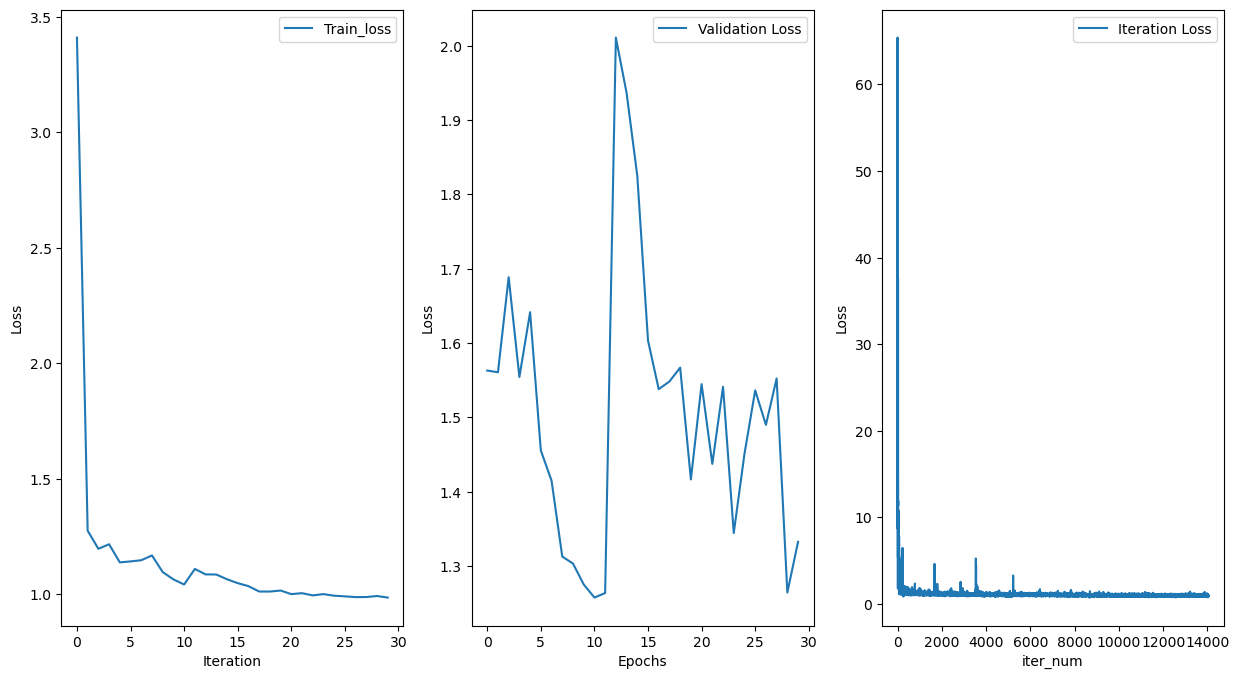

In [17]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 8))

axes[0].plot(range(N_epochs),losses,label="Train_loss")
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].legend()

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(range(tot_iters),adam_batch_loss,label="Iteration Loss")
axes[2].set_xlabel('iter_num')
axes[2].set_ylabel('Loss')
axes[2].legend()

In [18]:
x_d_test, x_c_test, y1_test, y2_test= x_d[37500:45000].to(device),x_c[30000:37500].to(device),y1[37500:45000],y2[37500:45000]

In [19]:
y1_pred,y2_pred = mmoe(x_d_test,x_c_test)
y1_pred=y1_pred.squeeze(1).detach().cpu().numpy()
y2_pred=y2_pred.squeeze(1).detach().cpu().numpy()

In [20]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_true,y_pred):
    # 获取 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # 计算 AUC
    calculated_auc = auc(fpr, tpr)
    print(f"Custom AUC: {calculated_auc}")
    return calculated_auc

In [21]:
auc1=get_auc(y1_test,y1_pred)
auc2=get_auc(y2_test,y2_pred)

Custom AUC: 0.8345217839905156
Custom AUC: 0.49972598335260954
